In [1]:
import numpy as np
import os
import sys
from glob import glob
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
import sklearn.utils as slu
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.ensemble import RandomForestClassifier

In [2]:
kfold = StratifiedKFold(n_splits = 10, shuffle= True, random_state=48)

In [3]:
def perform_metrics(clf_name, acc_list, pre_list, rec_list, f1_list, conf_list):
  acc_mean = round(np.mean(acc_list),3)
  acc_std = round(stdev(acc_list),3)
  pre_mean = round(np.mean(pre_list),3)
  pre_std = round(stdev(pre_list),3)
  rec_mean = round(np.mean(rec_list),3)
  rec_std = round(stdev(rec_list),3)
  f1_mean = round(np.mean(f1_list),3)
  f1_std = round(stdev(f1_list),3)
  print('Classifier Name: ',clf_name)
  print('accuracy mean: ',acc_mean,' std: ',acc_std)
  print('precision: ',pre_mean,' std: ',pre_std)
  print('recall: ',rec_mean,' std: ',rec_std)
  print('f1score: ',f1_mean,' std: ',f1_std)

  conf = np.mean(conf_list,axis=0)
  plt.figure(figsize=(8,8))
  sns.heatmap(conf,annot=True,fmt='.2%', cmap='Blues', xticklabels=categories,yticklabels=categories)
  plt.title(clf_name + ' confusion matrix')
  return (clf_name,acc_mean,acc_std,pre_mean,pre_std,rec_mean,rec_std,f1_mean,f1_std)

In [4]:
### Change path appropriately - will also save to this path with metric results.
path = '/content/drive/MyDrive/ecg/'

In [5]:
### Use mlii.csv generated by the notebook: Sampling MLII Beats Only for Generative Models in channel split folder
mlii = np.loadtxt(path+'channel_split/mlii.csv', delimiter=',')
print(mlii.shape)

(108828, 259)


In [6]:
np.random.shuffle(mlii)

X = mlii[:,:-3]
y = mlii[:,-3]
print(X.shape, y.shape)

(108828, 256) (108828,)


In [7]:
inputs = X
targets = y
categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']

In [14]:
def cross_val(inputs, targets, resamp_func, synth_model, file_type):
  cnn_acc_list = []
  cnn_pre_list = []
  cnn_rec_list = []
  cnn_f1_list = []
  cnn_conf_list = []

  rfc_acc_list = []
  rfc_pre_list = []
  rfc_rec_list = []
  rfc_f1_list = []
  rfc_conf_list = []


  from sklearn.utils import resample


  fold_no = 1

  for train, test in kfold.split(inputs, targets):

    xtr, xte = inputs[train], inputs[test]
    ytr, yte = targets[train], targets[test]

    ytr_res = ytr.reshape(-1,1)

    train_vals = np.concatenate((xtr, ytr_res), axis=1)
    print(train_vals.shape)
    if (resamp_func == 0) and (synth_model is None):
      xtr_new = xtr
      ytr_new = ytr

    elif (resamp_func != 0) and (synth_model is not None):

      new_train_vals = resamp_func(train_vals, synth_model)

      xtr_new = new_train_vals[:,:-1]
      ytr_new = new_train_vals[:,-1]

    else:

      new_train_vals = resamp_func(train_vals)

      xtr_new = new_train_vals[:,:-1]
      ytr_new = new_train_vals[:,-1]

    verbose, epoch, batch_size = 0, 10, 128
    inputs_3d_tr = xtr_new.reshape(-1, xtr_new.shape[1],1)
    inputs_3d_te = xte.reshape(-1, xte.shape[1],1)
    targets_cat_tr = to_categorical(ytr_new) 
    targets_cat_te = to_categorical(yte)
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(inputs_3d_tr.shape[1],inputs_3d_tr.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(64, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

    print('CNN, Fold number: ', fold_no)
    model = cnnmodel.fit(inputs_3d_tr, targets_cat_tr, epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)
    cnnpredictions = cnnmodel.predict(inputs_3d_te, verbose=1)
    y_pred_cnn = np.argmax(cnnpredictions, axis=1)
    cnn_actual = np.argmax(targets_cat_te, axis=1)

    cnn_acc_list.append(accuracy_score(cnn_actual, y_pred_cnn))
    cnn_pre_list.append(precision_score(cnn_actual, y_pred_cnn, average='macro'))
    cnn_rec_list.append(recall_score(cnn_actual, y_pred_cnn, average='macro'))
    cnn_f1_list.append(f1_score(cnn_actual, y_pred_cnn, average='macro'))
    cnn_cm = confusion_matrix(cnn_actual, y_pred_cnn)
    cnn_cm = cnn_cm.astype('float')/ cnn_cm.sum(axis=1)[:,np.newaxis]
    cnn_conf_list.append(cnn_cm)


    print('RFC, Fold Number: ', fold_no)
    rfc_clf = RandomForestClassifier(max_depth=10, random_state=48,n_estimators=10)
    rfc_clf.fit(xtr_new, ytr_new)
    y_pred_rfc = rfc_clf.predict(xte)
    rfc_acc_list.append(accuracy_score(yte, y_pred_rfc))
    rfc_pre_list.append(precision_score(yte, y_pred_rfc, average='macro'))
    rfc_rec_list.append(recall_score(yte, y_pred_rfc, average='macro'))
    rfc_f1_list.append(f1_score(yte, y_pred_rfc, average='macro'))
    rfc_cm = confusion_matrix(yte, y_pred_rfc)
    rfc_cm = rfc_cm.astype('float')/ rfc_cm.sum(axis=1)[:,np.newaxis]
    rfc_conf_list.append(rfc_cm)
    fold_no +=1

  CNN_results = perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)
  RFC_results = perform_metrics('RFC', rfc_acc_list, rfc_pre_list, rfc_rec_list, rfc_f1_list, rfc_conf_list)

  crossval_results = pd.DataFrame(data = (CNN_results, RFC_results))
  if not os.path.exists(path + 'metric_results/' + file_type):
    os.makedirs(path + 'metric_results/' + file_type)
  
  print(crossval_results)
  crossval_results.to_csv(path + 'metric_results/' + file_type + '/crossval_results.csv', encoding='utf-8', index=False)

  if not os.path.exists(path + 'metric_results/' + file_type + '/cnn'):
    os.makedirs(path + 'metric_results/' + file_type + '/cnn')
  
  cnn_unsamp = path + 'metric_results/' + file_type + '/cnn/'
  CNN_acc = pd.DataFrame(cnn_acc_list)
  CNN_acc.to_csv(cnn_unsamp + 'CNN_acc.csv', encoding='utf-8', index=False)

  CNN_pre = pd.DataFrame(cnn_pre_list)
  CNN_pre.to_csv(cnn_unsamp + 'CNN_pre.csv', encoding='utf-8', index=False)

  CNN_rec = pd.DataFrame(cnn_rec_list)
  CNN_rec.to_csv(cnn_unsamp +'CNN_rec.csv', encoding='utf-8', index=False)

  CNN_f1s = pd.DataFrame(cnn_f1_list)
  CNN_f1s.to_csv(cnn_unsamp +'CNN_f1s.csv', encoding='utf-8', index=False)

  if not os.path.exists(path + 'metric_results/' + file_type + '/rfc'):
    os.makedirs(path + 'metric_results/' + file_type + '/rfc')

  rfc_unsamp = path + 'metric_results/' + file_type + '/rfc/'
  rfc_acc = pd.DataFrame(rfc_acc_list)
  rfc_acc.to_csv(rfc_unsamp + 'RFC_acc.csv', encoding='utf-8', index=False)

  rfc_pre = pd.DataFrame(rfc_pre_list)
  rfc_pre.to_csv(rfc_unsamp + 'RFC_pre.csv', encoding='utf-8', index=False)

  rfc_rec = pd.DataFrame(rfc_rec_list)
  rfc_rec.to_csv(rfc_unsamp +'RFC_rec.csv', encoding='utf-8', index=False)

  rfc_f1s = pd.DataFrame(rfc_f1_list)
  rfc_f1s.to_csv(rfc_unsamp +'RFC_f1s.csv', encoding='utf-8', index=False)

In [9]:
## NAIVE RESAMPLING FUNCTIONS

import sklearn.utils as slu
seed=48
np.random.seed(seed)
def downsample(arr,n,seed):
    downsampled = slu.resample(arr,replace=False,n_samples=n,random_state=seed)
    return downsampled

def upsample(arr,n,seed):
    upsampled = slu.resample(arr,replace=True,n_samples=n,random_state=seed)
    return upsampled

def naive_resample(train_vals):
  anno = train_vals[:,-1]
  normal = train_vals[anno == 1.0]
  lbbb = train_vals[anno == 2.0]
  rbbb = train_vals[anno == 3.0]
  apb = train_vals[anno == 4.0]
  pvc = train_vals[anno == 5.0]
  fvn = train_vals[anno == 6.0]
  fpn = train_vals[anno == 7.0]
  paced = train_vals[anno == 8.0]

  abnormal = [lbbb,rbbb,apb,pvc,fvn,fpn,paced]
  list_len = [len(i) for i in abnormal]
  print(list_len)

  all_classes = [normal,lbbb,rbbb,apb,pvc,fvn,fpn,paced]

  num_of_vals = np.mean(list_len, dtype=int)
  print(num_of_vals)

  sampled_data = []
  for i in all_classes:
      if i.shape[0] > num_of_vals:
          i = downsample(i, num_of_vals,seed)
      elif i.shape[0] < num_of_vals:
          i = upsample(i, num_of_vals,seed)
      sampled_data.append(i)

  for i in sampled_data:
    print(i.shape)
  sampled_data = np.concatenate(sampled_data)
  np.random.shuffle(sampled_data)

  return sampled_data

In [10]:
## SMOTE RESAMPLING FUNCTIONS

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

def smote_rus(train_vals):
  X_train = train_vals[:,:-1]
  y_train = train_vals[:,-1]
  label_count = Counter(y_train)
  print(label_count)
  classes, counts = np.unique(y_train, return_counts=True)
  imbalanced = counts[1:]
  imb_max = np.max(imbalanced)
  print(imb_max)
  normal_count = counts[0]
  print(normal_count)

  samp_strat = {1:normal_count,2:imb_max,3:imb_max,4:imb_max,5:imb_max,6:imb_max,7:imb_max,8:imb_max}
  sm = SMOTE(random_state=42, sampling_strategy=samp_strat)
  X_bal, y_bal = sm.fit_resample(X_train,y_train)
  print(Counter(y_bal))

  rus = RandomUnderSampler()
  X_u,y_u = rus.fit_resample(X_bal,y_bal)
  print(Counter(y_u))

  y_u_res = y_u.reshape(-1,1)

  train_vals_new = np.concatenate((X_u, y_u_res), axis=1)

  return train_vals_new

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
## VAE RESAMPLING FUNCTIONS

comb = path + 'synthetic_data/combined/'
cnn_synth = np.genfromtxt(comb + 'cnn_synth.csv', delimiter=',')
cnn_sparse_synth = np.genfromtxt(comb + 'cnn_sparse_synth.csv', delimiter=',' )
lstm_synth = np.genfromtxt(comb + 'lstm_synth.csv', delimiter=',')
lstm_sparse_synth = np.genfromtxt(comb + 'lstm_sparse_synth.csv', delimiter=',')

print(cnn_synth.shape)
print(cnn_sparse_synth.shape)
print(lstm_synth.shape)
print(lstm_sparse_synth.shape)

def downsample(arr,n,seed):
    downsampled = slu.resample(arr,replace=False,n_samples=n,random_state=seed)
    return downsampled

def resample_vae(train_vals, synth_model):
  # compute number of values per class
  anno = train_vals[:,-1]
  normal = train_vals[anno == 1.0]
  lbbb = train_vals[anno == 2.0]
  rbbb = train_vals[anno == 3.0]
  apb = train_vals[anno == 4.0]
  pvc = train_vals[anno == 5.0]
  fvn = train_vals[anno == 6.0]
  fpn = train_vals[anno == 7.0]
  paced = train_vals[anno == 8.0]


  abnormal = [lbbb,rbbb,apb,pvc,fvn,fpn,paced]
  list_len = [len(i) for i in abnormal]
  print(list_len)
  print(len(normal))
  all_classes = [normal,lbbb,rbbb,apb,pvc,fvn,fpn,paced]

  num_of_vals = np.mean(list_len, dtype=int)
  print(num_of_vals)

  # downsample all classes to <= num_of_vals/2
  sampled_data = []
  for i in all_classes:
    # print(i.shape[0])
    if i.shape[0] > num_of_vals//2:
        i = downsample(i, num_of_vals//2,42)
    sampled_data.append(i)

  print(len(sampled_data))


  #segregate synth data into classes
  anno = synth_model[:,-1]
  normal_synth = synth_model[anno == 1.0]
  lbbb_synth = synth_model[anno == 2.0]
  rbbb_synth = synth_model[anno == 3.0]
  apb_synth = synth_model[anno == 4.0]
  pvc_synth = synth_model[anno == 5.0]
  fvn_synth = synth_model[anno == 6.0]
  fpn_synth = synth_model[anno == 7.0]
  paced_synth = synth_model[anno == 8.0]

  all_classes_synth = [normal_synth,lbbb_synth,rbbb_synth,apb_synth,pvc_synth,fvn_synth,fpn_synth,paced_synth]

  print(all_classes_synth[0].shape)

  # add the difference between the num of vals and downsampled real values to each class
  synth_real_data = []
  for i in range(len(sampled_data)):
    diff = num_of_vals - sampled_data[i].shape[0]
    # print(diff)
    synth_samps = all_classes_synth[i][np.random.choice(all_classes_synth[i].shape[0], diff, replace=False),:]
    # print(synth_samps.shape)
    # synth_samps = all_classes_synth[i][:diff]
    mixed = np.concatenate((sampled_data[i], synth_samps))
    # print(sampled_data[i].shape)
    synth_real_data.append(mixed)

  print(len(i) for i in synth_real_data)

  # combine into one array and shuffle to produce mix of synth and real data per class
  synth_real_arr = np.concatenate(synth_real_data, axis=0)
  np.random.shuffle(synth_real_arr)
  print(synth_real_arr.shape)

  return synth_real_arr



(47616, 257)
(47616, 257)
(47616, 257)
(47616, 257)


## CALLING CROSS VAL NOW

(97945, 257)
CNN, Fold number:  1
341/341 [==============================] - 1s 2ms/step
RFC, Fold Number:  1
(97945, 257)
CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2
(97945, 257)
CNN, Fold number:  3
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  3
(97945, 257)
CNN, Fold number:  4
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  4
(97945, 257)
CNN, Fold number:  5
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  5
(97945, 257)
CNN, Fold number:  6
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  6
(97945, 257)
CNN, Fold number:  7
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  7
(97945, 257)
CNN, Fold number:  8
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  8
(97946, 257)
CNN, Fold number:  9
341/341 [==============================] - 1s 2ms/step
RFC, Fold Number:  9
(97946, 25

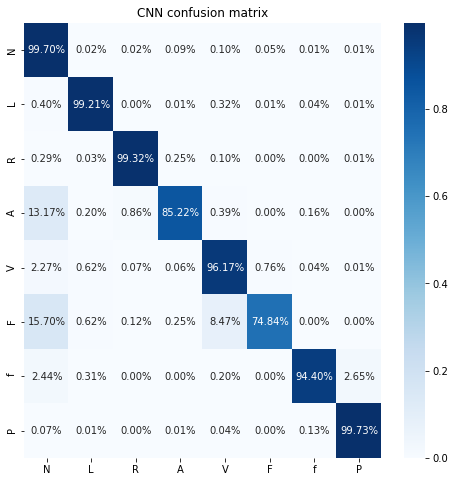

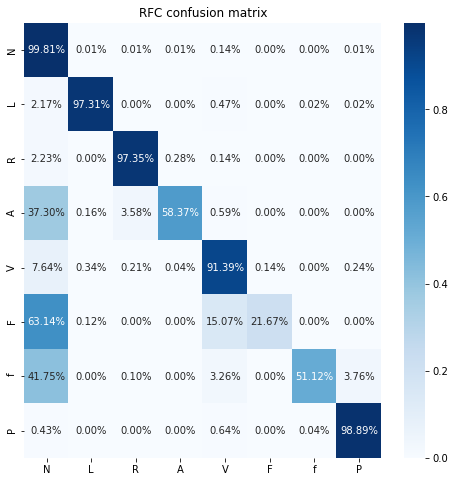

In [14]:
cross_val(inputs, targets, 0, None, 'unsampled')

(97945, 257)
[7264, 6531, 2290, 6417, 723, 884, 6321]
4347
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
CNN, Fold number:  1
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  1
(97945, 257)
[7264, 6530, 2290, 6417, 723, 884, 6322]
4347
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6322]
4347
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
CNN, Fold number:  3
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  3
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6322]
4347
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
(4347, 257)
CNN, Fold number:  4
341/341 [==============================] - 1s 2ms/step
RFC, Fold Num

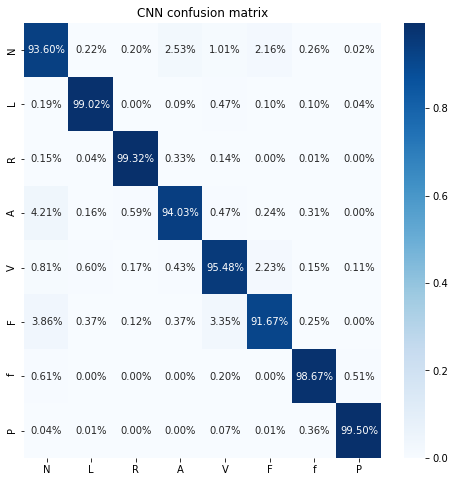

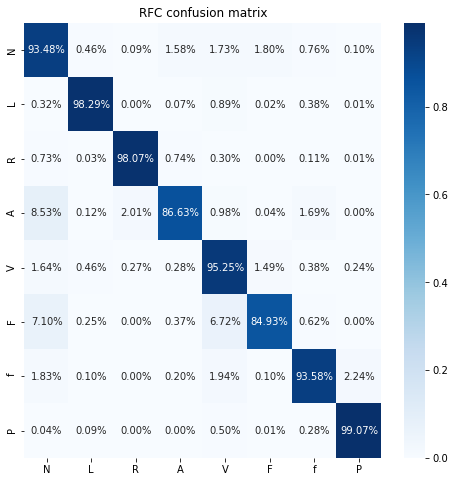

In [15]:
cross_val(inputs, targets, naive_resample, None, 'naive')

(97945, 257)
Counter({1.0: 67515, 2.0: 7264, 3.0: 6531, 5.0: 6417, 8.0: 6321, 4.0: 2290, 7.0: 884, 6.0: 723})
7264
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7264, 5.0: 7264, 3.0: 7264, 6.0: 7264, 2.0: 7264, 4.0: 7264, 7.0: 7264})
Counter({1.0: 7264, 2.0: 7264, 3.0: 7264, 4.0: 7264, 5.0: 7264, 6.0: 7264, 7.0: 7264, 8.0: 7264})
CNN, Fold number:  1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67515, 2.0: 7264, 3.0: 6530, 5.0: 6417, 8.0: 6322, 4.0: 2290, 7.0: 884, 6.0: 723})
7264
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7264, 5.0: 7264, 3.0: 7264, 6.0: 7264, 2.0: 7264, 4.0: 7264, 7.0: 7264})
Counter({1.0: 7264, 2.0: 7264, 3.0: 7264, 4.0: 7264, 5.0: 7264, 6.0: 7264, 7.0: 7264, 8.0: 7264})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67515, 2.0: 7265, 3.0: 6530, 5.0: 6417, 8.0: 6322, 4.0: 2289, 7.0: 884, 6.0: 723})
7265
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7265, 5.0: 7265, 3.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  3
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67515, 2.0: 7265, 3.0: 6530, 5.0: 6417, 8.0: 6322, 4.0: 2289, 7.0: 884, 6.0: 723})
7265
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7265, 5.0: 7265, 3.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})
CNN, Fold number:  4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67515, 2.0: 7265, 3.0: 6530, 5.0: 6417, 8.0: 6322, 4.0: 2289, 7.0: 884, 6.0: 723})
7265
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7265, 5.0: 7265, 3.0: 7265, 2.0: 7265, 4.0: 7265, 6.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  5
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67515, 2.0: 7265, 3.0: 6530, 5.0: 6417, 8.0: 6322, 4.0: 2289, 7.0: 884, 6.0: 723})
7265
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7265, 5.0: 7265, 3.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  6
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67515, 2.0: 7265, 3.0: 6530, 5.0: 6417, 8.0: 6322, 4.0: 2290, 7.0: 883, 6.0: 723})
7265
67515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67515, 8.0: 7265, 5.0: 7265, 3.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  7
341/341 [==============================] - 1s 2ms/step
RFC, Fold Number:  7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97945, 257)
Counter({1.0: 67516, 2.0: 7265, 3.0: 6531, 5.0: 6417, 8.0: 6321, 4.0: 2290, 7.0: 883, 6.0: 722})
7265
67516


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67516, 8.0: 7265, 5.0: 7265, 3.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  8
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97946, 257)
Counter({1.0: 67516, 2.0: 7265, 3.0: 6531, 5.0: 6417, 8.0: 6321, 4.0: 2290, 7.0: 884, 6.0: 722})
7265
67516


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67516, 8.0: 7265, 5.0: 7265, 3.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  9
341/341 [==============================] - 1s 2ms/step
RFC, Fold Number:  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97946, 257)
Counter({1.0: 67516, 2.0: 7265, 3.0: 6531, 5.0: 6417, 8.0: 6321, 4.0: 2290, 7.0: 884, 6.0: 722})
7265
67516


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 67516, 5.0: 7265, 3.0: 7265, 8.0: 7265, 6.0: 7265, 2.0: 7265, 4.0: 7265, 7.0: 7265})
Counter({1.0: 7265, 2.0: 7265, 3.0: 7265, 4.0: 7265, 5.0: 7265, 6.0: 7265, 7.0: 7265, 8.0: 7265})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CNN, Fold number:  10
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  10


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier Name:  CNN
accuracy mean:  0.897  std:  0.009
precision:  0.615  std:  0.02
recall:  0.842  std:  0.007
f1score:  0.673  std:  0.021
Classifier Name:  RFC
accuracy mean:  0.949  std:  0.002
precision:  0.795  std:  0.008
recall:  0.941  std:  0.006
f1score:  0.847  std:  0.007
     0      1      2      3      4      5      6      7      8
0  CNN  0.897  0.009  0.615  0.020  0.842  0.007  0.673  0.021
1  RFC  0.949  0.002  0.795  0.008  0.941  0.006  0.847  0.007


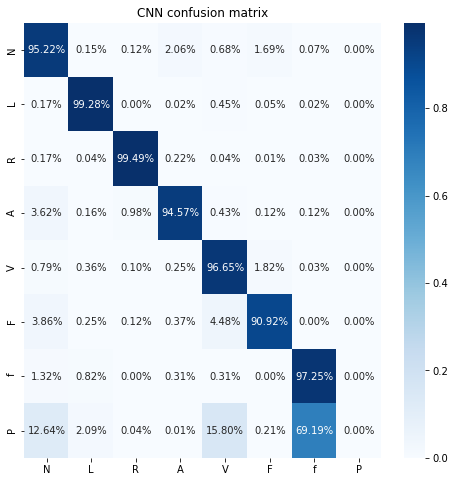

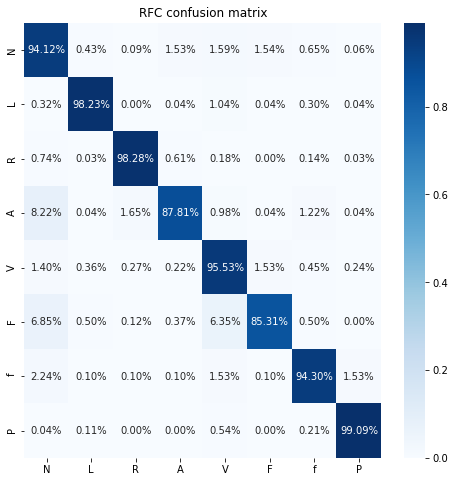

In [16]:
cross_val(inputs, targets, smote_rus, None, 'smote')

(97945, 257)
[7264, 6531, 2290, 6417, 723, 884, 6321]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f582a3c5450>
(34776, 257)
CNN, Fold number:  1
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  1
(97945, 257)
[7264, 6530, 2290, 6417, 723, 884, 6322]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f57e15e0350>
(34776, 257)
CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6322]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f57e04c8d50>
(34776, 257)
CNN, Fold number:  3
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  3
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6322]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f57e04c4cd0>
(34776, 257)
CNN, Fold number:  4
341/341 [==============================] - 1

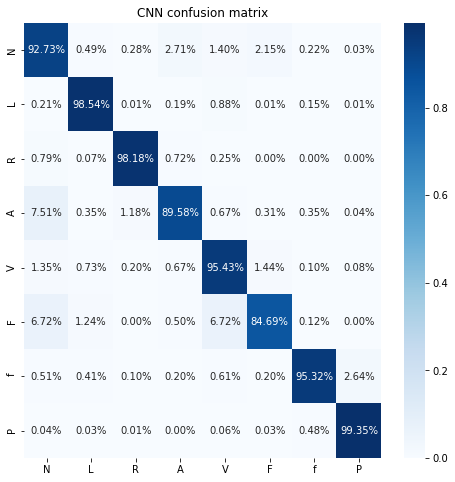

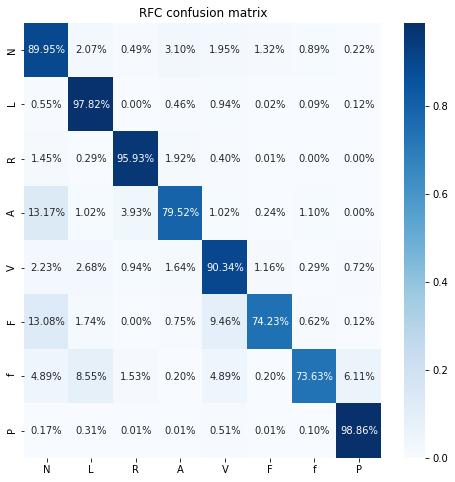

In [17]:
cross_val(inputs, targets, resample_vae, cnn_synth, 'mixed/cnn_synth')

(97945, 257)
<function resample_vae at 0x7f5e5024c710>
in correct place
[7265, 6531, 2289, 6417, 723, 884, 6321]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e50255a50>
(34776, 257)
CNN, Fold number:  1
341/341 [==============================] - 1s 2ms/step
RFC, Fold Number:  1
(97945, 257)
<function resample_vae at 0x7f5e5024c710>
in correct place
[7265, 6530, 2289, 6417, 723, 884, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e03b5a5d0>
(34776, 257)
CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2
(97945, 257)
<function resample_vae at 0x7f5e5024c710>
in correct place
[7265, 6530, 2289, 6417, 723, 884, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5dfcf9d0d0>
(34776, 257)
CNN, Fold number:  3
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  3
(97945, 257)
<function resample_vae at 0x7f5e5024

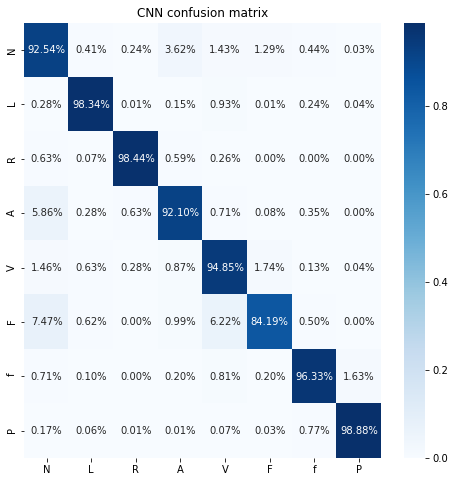

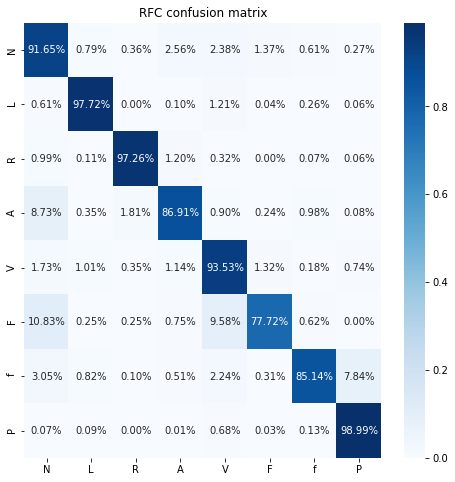

In [13]:
cross_val(inputs, targets, resample_vae, cnn_sparse_synth, 'mixed/cnn_sparse_synth')

(97945, 257)
[7265, 6531, 2289, 6417, 723, 884, 6321]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e4e631b50>
(34776, 257)
CNN, Fold number:  1
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  1
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e1ef57d50>
(34776, 257)
CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e037c1650>
(34776, 257)
CNN, Fold number:  3
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  3
(97945, 257)
[7265, 6530, 2290, 6417, 723, 883, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e502f2dd0>
(34776, 257)
CNN, Fold number:  4
341/341 [==============================] - 1

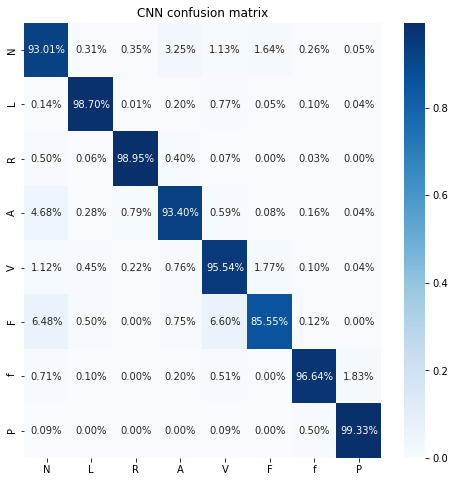

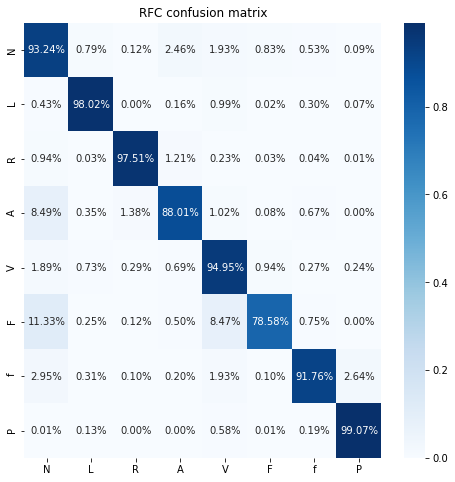

In [15]:
cross_val(inputs, targets, resample_vae, lstm_synth, 'mixed/lstm_synth')

(97945, 257)
[7265, 6531, 2289, 6417, 723, 884, 6321]
67515
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e1efc57d0>
(34776, 257)
CNN, Fold number:  1
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  1
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e0515ecd0>
(34776, 257)
CNN, Fold number:  2
341/341 [==============================] - 1s 1ms/step
RFC, Fold Number:  2
(97945, 257)
[7265, 6530, 2289, 6417, 723, 884, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5dfd78f650>
(34776, 257)
CNN, Fold number:  3
341/341 [==============================] - 1s 2ms/step
RFC, Fold Number:  3
(97945, 257)
[7265, 6530, 2290, 6417, 723, 883, 6321]
67516
4347
8
(5952, 257)
<generator object resample_vae.<locals>.<genexpr> at 0x7f5e0663aa50>
(34776, 257)
CNN, Fold number:  4
341/341 [==============================] - 1

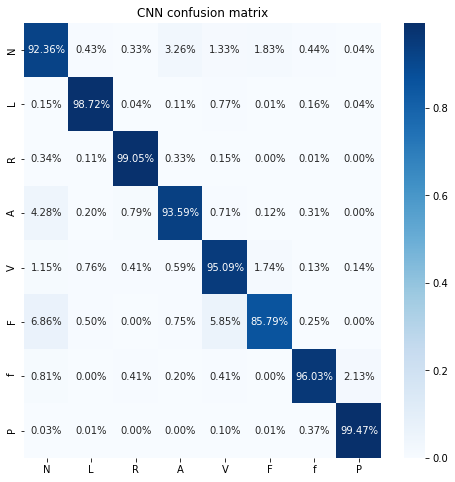

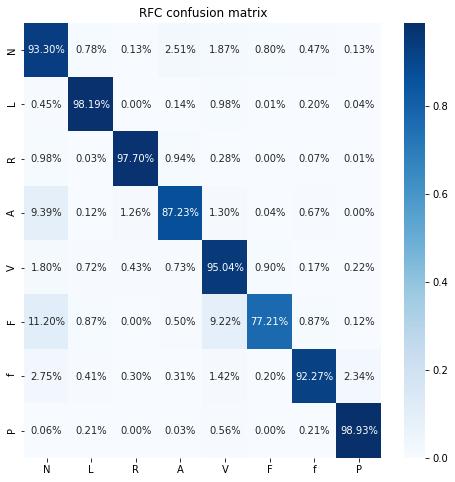

In [16]:
cross_val(inputs, targets, resample_vae, lstm_sparse_synth, 'mixed/lstm_sparse_synth')